Forecast stock close price for Algonquin Power & Utilities Corp.(ticker:AQN.TO) using deep learning and classical models\
Data source: Yahoo Finance\
Models built by: Gary Sampson, DatumSam AI

In [1]:
import pandas as pd
import yfinance as yf

In [2]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [3]:
# Download Algonquin Power & Utilities Corp. and S&P/TSX composite index from January 1,2010 to October 28, 2022
df = yf.download(['^GSPTSE', 'AQN.TO'], start='2010-01-01', end='2022-10-28', 
                    progress=False, auto_adjust=True)
df1 = df['Close']
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3217 entries, 2010-01-04 to 2022-10-27
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   AQN.TO   3217 non-null   float64
 1   ^GSPTSE  3217 non-null   float64
dtypes: float64(2)
memory usage: 75.4 KB


In [4]:
# make a copy of dataset df1
df2 = df1.copy()

In [5]:
# Original dataset did not have weekend and holiday data. Impute with forward fill data to produce timeseries dataset 
Date_new = pd.date_range(start='2010-01-04', end='2022-10-28', freq='D')
df2 = df2.reindex(Date_new, method='ffill' )
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4681 entries, 2010-01-04 to 2022-10-28
Freq: D
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   AQN.TO   4681 non-null   float64
 1   ^GSPTSE  4681 non-null   float64
dtypes: float64(2)
memory usage: 109.7 KB


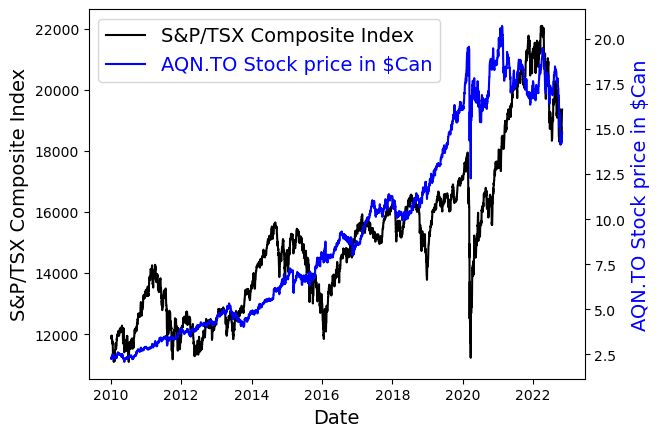

In [6]:
# Plot S&P/TSX Composite index and AQN.TO with different scales on the same plot
from mpl_toolkits.axes_grid1 import host_subplot

host = host_subplot(111)
par = host.twinx()

host.set_xlabel("Date")
host.set_ylabel("S&P/TSX Composite Index")
par.set_ylabel("AQN.TO Stock price in $Can")
               
p1, = host.plot(df2['^GSPTSE'],'k', label="S&P/TSX Composite Index")
p2, = par.plot(df2['AQN.TO'],'b', label="AQN.TO Stock price in $Can") 

host.legend(labelcolor="linecolor")

host.yaxis.get_label().set_color(p1.get_color())
par.yaxis.get_label().set_color(p2.get_color())

plt.show()

## Forecast AQN.TO stock price using a univariate time series

In [7]:
df_univar = df2['AQN.TO']

In [8]:
# Split the series into train, validate and test sets
df_uni_train = df_univar["2010-01-04":"2019-12-31"]
df_uni_valid = df_univar["2021-01-01":"2022-09-01"]
df_uni_test = df_univar["2022-09-01":]

In [9]:
# normalize train,validate and test datasets using mean and std
train_mean = df_uni_train.mean()
train_std = df_uni_train.std()

df_train_scaled = (df_uni_train - train_mean)/train_std
df_valid_scaled = (df_uni_valid - train_mean)/train_std
df_test_scaled = (df_uni_test - train_mean)/train_std

In [10]:
print('train mean:', train_mean)
print('train std:', train_std)

train mean: 7.051271865778866
train std: 3.6285279714491336


In [11]:
# Create utilities functions to prepare train and validation data
import tensorflow as tf

def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [12]:
# Create sequence to sequence dataset for univariate time series
def to_seq2seq_dataset(series, seq_length=30, ahead=7, batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:]))
    if shuffle:
        ds = ds.shuffle(10 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [13]:
seq2seq_train_uni = to_seq2seq_dataset(df_train_scaled, shuffle=True, seed=42)
seq2seq_valid_uni = to_seq2seq_dataset(df_valid_scaled)
seq2seq_test_uni = to_seq2seq_dataset(df_test_scaled)

In [14]:
# lstm baseline
tf.keras.backend.clear_session()
tf.random.set_seed(42)

lstm_model_1 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None,1]),
    tf.keras.layers.Dense(7) 
])

In [15]:
def fit_and_evaluate_rnn(model, train_set, valid_set, epochs=300):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=20, restore_best_weights=True)
    model.compile(loss=tf.keras.losses.Huber(), optimizer="adam", metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    return 

In [16]:
fit_and_evaluate_rnn(lstm_model_1, seq2seq_train_uni, seq2seq_valid_uni)

Epoch 1/300
113/113 [==============================] - 10s 22ms/step - loss: 0.1892 - mae: 0.4909 - val_loss: 0.7394 - val_mae: 1.2280
Epoch 2/300
113/113 [==============================] - 1s 9ms/step - loss: 0.0446 - mae: 0.2012 - val_loss: 0.3861 - val_mae: 0.7953
Epoch 3/300
113/113 [==============================] - 1s 9ms/step - loss: 0.0285 - mae: 0.1476 - val_loss: 0.2673 - val_mae: 0.6116
Epoch 4/300
113/113 [==============================] - 1s 9ms/step - loss: 0.0205 - mae: 0.1148 - val_loss: 0.2093 - val_mae: 0.5125
Epoch 5/300
113/113 [==============================] - 1s 9ms/step - loss: 0.0162 - mae: 0.0956 - val_loss: 0.1664 - val_mae: 0.4259
Epoch 6/300
113/113 [==============================] - 1s 9ms/step - loss: 0.0132 - mae: 0.0823 - val_loss: 0.1413 - val_mae: 0.3807
Epoch 7/300
113/113 [==============================] - 1s 9ms/step - loss: 0.0111 - mae: 0.0731 - val_loss: 0.1169 - val_mae: 0.3220
Epoch 8/300
113/113 [==============================] - 1s 9ms/step 

Epoch 61/300
113/113 [==============================] - 1s 9ms/step - loss: 8.0430e-04 - mae: 0.0278 - val_loss: 0.0070 - val_mae: 0.0801
Epoch 62/300
113/113 [==============================] - 1s 9ms/step - loss: 7.5093e-04 - mae: 0.0259 - val_loss: 0.0070 - val_mae: 0.0794
Epoch 63/300
113/113 [==============================] - 1s 9ms/step - loss: 7.5175e-04 - mae: 0.0259 - val_loss: 0.0072 - val_mae: 0.0825
Epoch 64/300
113/113 [==============================] - 1s 9ms/step - loss: 7.4883e-04 - mae: 0.0259 - val_loss: 0.0072 - val_mae: 0.0840
Epoch 65/300
113/113 [==============================] - 1s 9ms/step - loss: 7.4602e-04 - mae: 0.0258 - val_loss: 0.0069 - val_mae: 0.0798
Epoch 66/300
113/113 [==============================] - 1s 10ms/step - loss: 7.5526e-04 - mae: 0.0260 - val_loss: 0.0071 - val_mae: 0.0827
Epoch 67/300
113/113 [==============================] - 1s 10ms/step - loss: 7.5262e-04 - mae: 0.0261 - val_loss: 0.0070 - val_mae: 0.0830
Epoch 68/300
113/113 [==========

Using GRUs

In [17]:
# GRU baseline
tf.keras.backend.clear_session()
tf.random.set_seed(42)

gru_model_1 = tf.keras.models.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None,1]),
    tf.keras.layers.Dense(7) 
])

In [18]:
fit_and_evaluate_rnn(gru_model_1, seq2seq_train_uni, seq2seq_valid_uni)

Epoch 1/300
113/113 [==============================] - 3s 14ms/step - loss: 0.1450 - mae: 0.4190 - val_loss: 0.4245 - val_mae: 0.8830
Epoch 2/300
113/113 [==============================] - 1s 10ms/step - loss: 0.0166 - mae: 0.1017 - val_loss: 0.2263 - val_mae: 0.6000
Epoch 3/300
113/113 [==============================] - 1s 10ms/step - loss: 0.0101 - mae: 0.0717 - val_loss: 0.1551 - val_mae: 0.4746
Epoch 4/300
113/113 [==============================] - 1s 10ms/step - loss: 0.0077 - mae: 0.0634 - val_loss: 0.1164 - val_mae: 0.3984
Epoch 5/300
113/113 [==============================] - 1s 10ms/step - loss: 0.0060 - mae: 0.0570 - val_loss: 0.0926 - val_mae: 0.3483
Epoch 6/300
113/113 [==============================] - 1s 10ms/step - loss: 0.0047 - mae: 0.0518 - val_loss: 0.0727 - val_mae: 0.2994
Epoch 7/300
113/113 [==============================] - 1s 10ms/step - loss: 0.0038 - mae: 0.0472 - val_loss: 0.0605 - val_mae: 0.2711
Epoch 8/300
113/113 [==============================] - 1s 10ms

Fine tune LSTM Hyperparameters

In [19]:
import keras_tuner as kt

In [21]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

def build_lstm_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=3)
    units = hp.Int("units", min_value=24, max_value=32)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-3,
                             sampling="log")
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    lstm_hp_model = tf.keras.Sequential()
    lstm_hp_model.add(tf.keras.layers.InputLayer(input_shape=[None,1]))
    for _ in range(n_hidden):
        lstm_hp_model.add(tf.keras.layers.LSTM(units,return_sequences=True))
    lstm_hp_model.add(tf.keras.layers.Dense(7))
    lstm_hp_model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,
                  metrics=["mae"])
    return lstm_hp_model

In [22]:
# using random search
random_search_tuner_lstm = kt.RandomSearch(
    build_lstm_model, objective="val_mae", max_trials=10, overwrite=True,
    directory="stock_price", project_name="lstm_rnd_search_rev1",seed=42)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=20, restore_best_weights=True)
random_search_tuner_lstm.search(seq2seq_train_uni, validation_data=seq2seq_valid_uni, epochs=300,
                              callbacks=[early_stopping_cb])

Trial 10 Complete [00h 04m 13s]
val_mae: 0.07916700094938278

Best val_mae So Far: 0.07668852806091309
Total elapsed time: 00h 31m 10s
INFO:tensorflow:Oracle triggered exit


In [23]:
top3_lstm_models = random_search_tuner_lstm.get_best_models(num_models=3)
lstm_best_model = top3_lstm_models[0]

In [24]:
# best hyperparameter values
top3_lstm_params = random_search_tuner_lstm.get_best_hyperparameters(num_trials=3)
top3_lstm_params[0].values 

{'n_hidden': 1, 'units': 32, 'learning_rate': 0.00041413456218069195}

In [25]:
tf.keras.backend.clear_session()

# Build a GRU model
def build_gru_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=3)
    units = hp.Int("units", min_value=24, max_value=32)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-3,
                             sampling="log")
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    gru_hp_model = tf.keras.Sequential()
    gru_hp_model.add(tf.keras.layers.InputLayer(input_shape=[None,1]))
    for _ in range(n_hidden):
        gru_hp_model.add(tf.keras.layers.GRU(units,return_sequences=True))
    gru_hp_model.add(tf.keras.layers.Dense(7))
    gru_hp_model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,
                  metrics=["mae"])
    return gru_hp_model

In [26]:
# using random search
random_search_tuner_gru = kt.RandomSearch(
    build_gru_model, objective="val_mae", max_trials=10, overwrite=True,
    directory="stock_price", project_name="gru_rnd_search_rev1",seed=42)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=20, restore_best_weights=True)
random_search_tuner_gru.search(seq2seq_train_uni, validation_data=seq2seq_valid_uni, epochs=300,
                              callbacks=[early_stopping_cb])

Trial 10 Complete [00h 03m 29s]
val_mae: 0.08860157430171967

Best val_mae So Far: 0.07569700479507446
Total elapsed time: 00h 32m 58s
INFO:tensorflow:Oracle triggered exit


In [27]:
top3_gru_models = random_search_tuner_gru.get_best_models(num_models=3)
gru_best_model = top3_gru_models[0]

In [28]:
# best hyperparameter values
top3_gru_params = random_search_tuner_gru.get_best_hyperparameters(num_trials=3)
top3_gru_params[0].values 

{'n_hidden': 1, 'units': 25, 'learning_rate': 0.0005516567488527182}

In [29]:
# Normalize train,validate and test datasets using min-max scaler
# Historically the stock price for AQN.TO has never exceed $100 CAN

df_train_scaled_1 = df_uni_train/100
df_valid_scaled_1 = df_uni_valid/100
df_test_scaled_1 = df_uni_test/100

In [30]:
seq2seq_train_uni_1 = to_seq2seq_dataset(df_train_scaled_1, shuffle=True, seed=42)
seq2seq_valid_uni_1 = to_seq2seq_dataset(df_valid_scaled_1)

In [31]:
tf.keras.backend.clear_session()
# Build lstm model

def build_lstm_model_1(hp):
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=3)
    units = hp.Int("units", min_value=24, max_value=32)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-3,
                             sampling="log")
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    lstm_hp_model_1 = tf.keras.Sequential()
    lstm_hp_model_1.add(tf.keras.layers.InputLayer(input_shape=[None,1]))
    for _ in range(n_hidden):
        lstm_hp_model_1.add(tf.keras.layers.LSTM(units,return_sequences=True))
    lstm_hp_model_1.add(tf.keras.layers.Dense(7))
    lstm_hp_model_1.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,
                  metrics=["mae"])
    return lstm_hp_model_1

In [32]:
# using random search
random_search_tuner_lstm_1 = kt.RandomSearch(
    build_lstm_model_1, objective="val_mae", max_trials=10, overwrite=True,
    directory="stock_price", project_name="lstm1_rnd_search_rev1",seed=42)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=20, restore_best_weights=True)
random_search_tuner_lstm_1.search(seq2seq_train_uni_1, validation_data=seq2seq_valid_uni_1, epochs=300,
                              callbacks=[early_stopping_cb])

Trial 10 Complete [00h 04m 03s]
val_mae: 0.002446848899126053

Best val_mae So Far: 0.0024084632750600576
Total elapsed time: 00h 33m 22s
INFO:tensorflow:Oracle triggered exit


In [33]:
top3_lstm1_models = random_search_tuner_lstm_1.get_best_models(num_models=3)
lstm1_best_model = top3_lstm1_models[0]

In [34]:
# best hyperparameter values
top3_lstm1_params = random_search_tuner_lstm_1.get_best_hyperparameters(num_trials=3)
top3_lstm1_params[0].values 

{'n_hidden': 1, 'units': 32, 'learning_rate': 0.00041413456218069195}

In [35]:
# Build model with best hyperparameters
tf.keras.backend.clear_session()

lstm_model_2 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None,1]),
    tf.keras.layers.Dense(7) 
])

opt = tf.keras.optimizers.Adam(learning_rate=0.000414)
lstm_model_2.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=20, restore_best_weights=True)
history_lstm2 = lstm_model_2.fit(seq2seq_train_uni_1, validation_data=seq2seq_valid_uni_1, epochs=300,
                                  callbacks=[early_stopping_cb])

Epoch 1/300
113/113 [==============================] - 3s 14ms/step - loss: 1.6847e-04 - mae: 0.0130 - val_loss: 9.8285e-04 - val_mae: 0.0363
Epoch 2/300
113/113 [==============================] - 1s 10ms/step - loss: 2.4796e-04 - mae: 0.0161 - val_loss: 6.4157e-04 - val_mae: 0.0267
Epoch 3/300
113/113 [==============================] - 1s 10ms/step - loss: 2.5509e-04 - mae: 0.0159 - val_loss: 5.5890e-04 - val_mae: 0.0243
Epoch 4/300
113/113 [==============================] - 1s 10ms/step - loss: 2.0493e-04 - mae: 0.0141 - val_loss: 4.7186e-04 - val_mae: 0.0200
Epoch 5/300
113/113 [==============================] - 1s 10ms/step - loss: 1.5346e-04 - mae: 0.0121 - val_loss: 4.1453e-04 - val_mae: 0.0169
Epoch 6/300
113/113 [==============================] - 1s 10ms/step - loss: 1.1008e-04 - mae: 0.0099 - val_loss: 3.8112e-04 - val_mae: 0.0144
Epoch 7/300
113/113 [==============================] - 1s 10ms/step - loss: 7.9348e-05 - mae: 0.0081 - val_loss: 3.4930e-04 - val_mae: 0.0125
Epoch 

Epoch 114/300
113/113 [==============================] - 1s 10ms/step - loss: 9.5728e-07 - mae: 9.3673e-04 - val_loss: 6.4834e-06 - val_mae: 0.0026
Epoch 115/300
113/113 [==============================] - 1s 10ms/step - loss: 9.5994e-07 - mae: 9.3828e-04 - val_loss: 6.1073e-06 - val_mae: 0.0025
Epoch 116/300
113/113 [==============================] - 1s 9ms/step - loss: 9.4377e-07 - mae: 9.2769e-04 - val_loss: 6.5048e-06 - val_mae: 0.0026
Epoch 117/300
113/113 [==============================] - 1s 10ms/step - loss: 9.6458e-07 - mae: 9.4561e-04 - val_loss: 6.1533e-06 - val_mae: 0.0025
Epoch 118/300
113/113 [==============================] - 1s 10ms/step - loss: 9.6244e-07 - mae: 9.4312e-04 - val_loss: 6.3817e-06 - val_mae: 0.0025
Epoch 119/300
113/113 [==============================] - 1s 10ms/step - loss: 9.5211e-07 - mae: 9.3643e-04 - val_loss: 6.1856e-06 - val_mae: 0.0025
Epoch 120/300
113/113 [==============================] - 1s 9ms/step - loss: 9.5479e-07 - mae: 9.3801e-04 - val_l

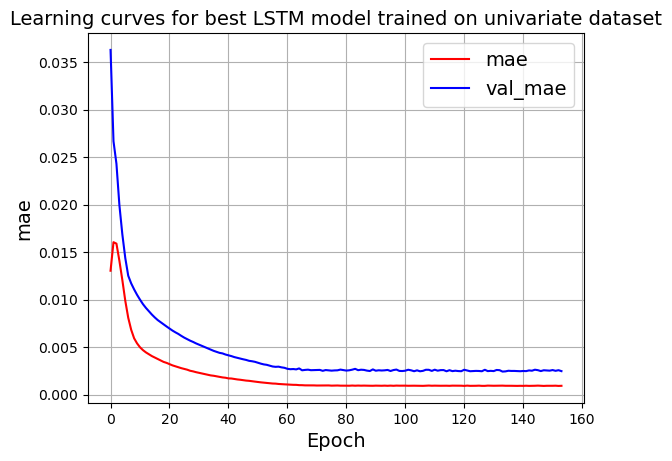

In [36]:
plt.plot(pd.DataFrame(history_lstm2.history["mae"]),"r", label="mae")
plt.plot(pd.DataFrame(history_lstm2.history["val_mae"]), "b", label="val_mae")
plt.xlabel("Epoch")
plt.ylabel("mae")
plt.title("Learning curves for best LSTM model trained on univariate dataset")
plt.grid()
plt.legend() 
plt.show()

In [38]:
seq2seq_test_uni_1 = to_seq2seq_dataset(df_test_scaled_1)
lstm_model_2.evaluate(seq2seq_test_uni_1)

1/1 [==============================] - 0s 78ms/step - loss: 1.9884e-05 - mae: 0.0048


[1.9883686036337167e-05, 0.004804856609553099]

In [39]:
tf.keras.backend.clear_session()
# Build gru model

def build_gru_model_1(hp):
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=3)
    units = hp.Int("units", min_value=24, max_value=32)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-3,
                             sampling="log")
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    gru_hp_model_1 = tf.keras.Sequential()
    gru_hp_model_1.add(tf.keras.layers.InputLayer(input_shape=[None,1]))
    for _ in range(n_hidden):
        gru_hp_model_1.add(tf.keras.layers.GRU(units,return_sequences=True))
    gru_hp_model_1.add(tf.keras.layers.Dense(7))
    gru_hp_model_1.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,
                  metrics=["mae"])
    return gru_hp_model_1

In [40]:
# using random search
random_search_tuner_gru_1 = kt.RandomSearch(
    build_gru_model_1, objective="val_mae", max_trials=10, overwrite=True,
    directory="stock_price", project_name="gru1_rnd_search_rev1",seed=42)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=20, restore_best_weights=True)
random_search_tuner_gru_1.search(seq2seq_train_uni_1, validation_data=seq2seq_valid_uni_1, epochs=300,
                              callbacks=[early_stopping_cb])

Trial 10 Complete [00h 02m 19s]
val_mae: 0.0023802421055734158

Best val_mae So Far: 0.002372429706156254
Total elapsed time: 00h 25m 08s
INFO:tensorflow:Oracle triggered exit


In [41]:
top3_gru1_models = random_search_tuner_gru_1.get_best_models(num_models=3)
gru1_best_model = top3_gru1_models[0]

In [42]:
# best hyperparameter values
top3_gru1_params = random_search_tuner_gru_1.get_best_hyperparameters(num_trials=3)
top3_gru1_params[0].values

{'n_hidden': 1, 'units': 32, 'learning_rate': 0.00041413456218069195}

In [43]:
# Build model with best hyperparameters
tf.keras.backend.clear_session()

gru_model_2 = tf.keras.models.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None,1]),
    tf.keras.layers.Dense(7) 
])

opt = tf.keras.optimizers.Adam(learning_rate=0.000414)
gru_model_2.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=20, restore_best_weights=True)
history_gru2 = gru_model_2.fit(seq2seq_train_uni_1, validation_data=seq2seq_valid_uni_1, epochs=300,
                                  callbacks=[early_stopping_cb])

Epoch 1/300
113/113 [==============================] - 3s 14ms/step - loss: 8.7927e-05 - mae: 0.0093 - val_loss: 6.9335e-04 - val_mae: 0.0330
Epoch 2/300
113/113 [==============================] - 1s 10ms/step - loss: 2.0332e-04 - mae: 0.0134 - val_loss: 4.5868e-04 - val_mae: 0.0252
Epoch 3/300
113/113 [==============================] - 1s 11ms/step - loss: 1.8992e-04 - mae: 0.0127 - val_loss: 3.5570e-04 - val_mae: 0.0215
Epoch 4/300
113/113 [==============================] - 1s 9ms/step - loss: 1.5393e-04 - mae: 0.0115 - val_loss: 2.9078e-04 - val_mae: 0.0190
Epoch 5/300
113/113 [==============================] - 1s 9ms/step - loss: 1.1855e-04 - mae: 0.0101 - val_loss: 2.2260e-04 - val_mae: 0.0157
Epoch 6/300
113/113 [==============================] - 1s 9ms/step - loss: 8.8839e-05 - mae: 0.0088 - val_loss: 1.8259e-04 - val_mae: 0.0135
Epoch 7/300
113/113 [==============================] - 1s 10ms/step - loss: 6.5872e-05 - mae: 0.0075 - val_loss: 1.4527e-04 - val_mae: 0.0107
Epoch 8/3

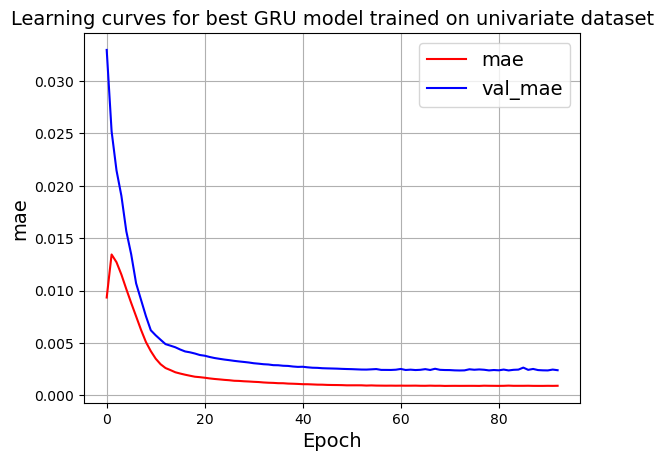

In [44]:
plt.plot(pd.DataFrame(history_gru2.history["mae"]),"r", label="mae")
plt.plot(pd.DataFrame(history_gru2.history["val_mae"]), "b", label="val_mae")
plt.xlabel("Epoch")
plt.ylabel("mae")
plt.title("Learning curves for best GRU model trained on univariate dataset")
plt.grid()
plt.legend() 
plt.show()

In [45]:
# Evaluate best GRU model
gru_model_2.evaluate(seq2seq_test_uni_1)

1/1 [==============================] - 0s 84ms/step - loss: 1.9434e-05 - mae: 0.0047


[1.9433771740295924e-05, 0.004715986084192991]

In [46]:
# Save the best RNN model trained on univariate dataset
import os

model_version = "0002"
model_name = "best_univariate_rnn"
model_path = os.path.join(model_name, model_version)
tf.saved_model.save(gru_model_2, model_path)

INFO:tensorflow:Assets written to: best_univariate_rnn\0002\assets


INFO:tensorflow:Assets written to: best_univariate_rnn\0002\assets


In [47]:
# Using AQN.TO close stock price from 2022-09-01 to 2022-09-30(30 days) to predict 2022-10-01 to 2022-10-07(7 days) 
# predict 5 days of AQN.to close stock prices from 2022-10-3 to 2022-10-07 using best gru model(gru_model_2)

x_test_uni = df_test_scaled_1[:30]
y_pred_gru2 = gru_model_2.predict(x_test_uni)[0,-1]
print('AQN.TO stock price Oct 3 - 7,2022:',df_uni_test["2022-10-03":"2022-10-07"])
print('y_pred:',y_pred_gru2[-5:]*100)

1/1 [==============================] - 0s 277ms/step
AQN.TO stock price Oct 3 - 7,2022: 2022-10-03    15.59
2022-10-04    15.86
2022-10-05    15.45
2022-10-06    14.89
2022-10-07    14.74
Freq: D, Name: AQN.TO, dtype: float64
y_pred: [17.751156 17.819828 17.910511 17.830614 17.819626]


In [48]:
# 5 day Mean Absolute error for AQN.to close stock prices from October 3 October 7, 2022
err = tf.keras.metrics.MeanAbsoluteError()
err.update_state(df_uni_test["2022-10-03":"2022-10-07"], y_pred_gru2[-5:]*100)
print("Mean Absolut Error for AQN.TO stock close prices from October 3 to October 7, 2022:Can$",err.result().numpy())

Mean Absolut Error for AQN.TO stock close prices from October 3 to October 7, 2022:Can$ 2.520347


## Forecast AQN.TO stock price using a multivariate time series

In [49]:
df2_multivar = df2

In [50]:
# Split the multivariate dataset into train, validate and test sets
df_multi_train = df2_multivar["2010-01-04":"2019-12-31"]
df_multi_valid = df2_multivar["2021-01-01":"2022-09-01"]
df_multi_test = df2_multivar["2022-09-01":]

In [51]:
# Normalize the multivariate dataset
multi_train_mean = df_multi_train.mean()
multi_train_std = df_multi_train.std()

multi_train_scaled = (df_multi_train - multi_train_mean)/multi_train_std
multi_valid_scaled = (df_multi_valid - multi_train_mean)/multi_train_std
multi_test_scaled = (df_multi_test - multi_train_mean)/multi_train_std

In [52]:
# For multivariate time series,target_col=0 for AQN.TO
def to_seq2seq_dataset_multi(series, seq_length=30, ahead=7, target_col=0,
                       batch_size=32, shuffle=False, seed=None): 
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 0]))
    if shuffle:
        ds = ds.shuffle(10 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [53]:
multi_train = to_seq2seq_dataset_multi(multi_train_scaled, shuffle=True, seed=42)
multi_valid = to_seq2seq_dataset_multi(multi_valid_scaled)
multi_test = to_seq2seq_dataset_multi(multi_test_scaled)

In [54]:
# Build lstm model for multivariate series

def build_lstm_model_2(hp):
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=3)
    units = hp.Int("units", min_value=24, max_value=32)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-3,
                             sampling="log")
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    lstm_hp_model_2 = tf.keras.Sequential()
    lstm_hp_model_2.add(tf.keras.layers.InputLayer(input_shape=[None, 2]))
    for _ in range(n_hidden):
        lstm_hp_model_2.add(tf.keras.layers.LSTM(units,return_sequences=True))
    lstm_hp_model_2.add(tf.keras.layers.Dense(7))
    lstm_hp_model_2.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,
                  metrics=["mae"])
    return lstm_hp_model_2

In [55]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

# using random search
random_search_tuner_lstm_multi = kt.RandomSearch(
    build_lstm_model_2, objective="val_mae", max_trials=10, overwrite=True,
    directory="stock_price", project_name="lstm_rnd_search_multi_rev1",seed=42)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=20, restore_best_weights=True)
random_search_tuner_lstm_multi.search(multi_train, validation_data=multi_valid, epochs=300,
                              callbacks=[early_stopping_cb])

Trial 10 Complete [00h 04m 52s]
val_mae: 0.09383954107761383

Best val_mae So Far: 0.09061619639396667
Total elapsed time: 00h 31m 10s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [56]:
top3_lstm_multi_models = random_search_tuner_lstm_multi.get_best_models(num_models=3)
lstm_multi_best_model = top3_lstm_multi_models[0]

In [57]:
# best hyperparameter values
top3_lstm_multi_params = random_search_tuner_lstm_multi.get_best_hyperparameters(num_trials=3)
top3_lstm_multi_params[0].values

{'n_hidden': 3, 'units': 25, 'learning_rate': 0.0009245261253931151}

In [58]:
# Build model with best hyperparameters
tf.keras.backend.clear_session()

lstm_multi = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(25, return_sequences=True, input_shape=[None,2]),
    tf.keras.layers.LSTM(25, return_sequences=True),
    tf.keras.layers.LSTM(25, return_sequences=True),
    tf.keras.layers.Dense(7) 
])

opt = tf.keras.optimizers.Adam(learning_rate=0.0009245)
lstm_multi.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=20, restore_best_weights=True)
history_lstm_multi = lstm_multi.fit(multi_train, validation_data=multi_valid, epochs=300,
                                  callbacks=[early_stopping_cb])

Epoch 1/300
113/113 [==============================] - 6s 27ms/step - loss: 0.2117 - mae: 0.5224 - val_loss: 0.9192 - val_mae: 1.4154
Epoch 2/300
113/113 [==============================] - 2s 17ms/step - loss: 0.1177 - mae: 0.3779 - val_loss: 0.6611 - val_mae: 1.1439
Epoch 3/300
113/113 [==============================] - 2s 18ms/step - loss: 0.0835 - mae: 0.3140 - val_loss: 0.4634 - val_mae: 0.9059
Epoch 4/300
113/113 [==============================] - 2s 18ms/step - loss: 0.0594 - mae: 0.2481 - val_loss: 0.3782 - val_mae: 0.7980
Epoch 5/300
113/113 [==============================] - 2s 16ms/step - loss: 0.0430 - mae: 0.1988 - val_loss: 0.3117 - val_mae: 0.7060
Epoch 6/300
113/113 [==============================] - 2s 16ms/step - loss: 0.0319 - mae: 0.1635 - val_loss: 0.2439 - val_mae: 0.5927
Epoch 7/300
113/113 [==============================] - 2s 15ms/step - loss: 0.0253 - mae: 0.1418 - val_loss: 0.1945 - val_mae: 0.5003
Epoch 8/300
113/113 [==============================] - 2s 16ms

113/113 [==============================] - 2s 15ms/step - loss: 7.3431e-04 - mae: 0.0262 - val_loss: 0.0107 - val_mae: 0.1024
Epoch 62/300
113/113 [==============================] - 2s 16ms/step - loss: 7.2564e-04 - mae: 0.0258 - val_loss: 0.0142 - val_mae: 0.1275
Epoch 63/300
113/113 [==============================] - 2s 16ms/step - loss: 8.3472e-04 - mae: 0.0289 - val_loss: 0.0095 - val_mae: 0.0954
Epoch 64/300
113/113 [==============================] - 2s 16ms/step - loss: 7.8677e-04 - mae: 0.0279 - val_loss: 0.0098 - val_mae: 0.0973
Epoch 65/300
113/113 [==============================] - 2s 16ms/step - loss: 7.3010e-04 - mae: 0.0261 - val_loss: 0.0117 - val_mae: 0.1108
Epoch 66/300
113/113 [==============================] - 2s 16ms/step - loss: 7.3361e-04 - mae: 0.0266 - val_loss: 0.0119 - val_mae: 0.1120
Epoch 67/300
113/113 [==============================] - 2s 16ms/step - loss: 7.1099e-04 - mae: 0.0256 - val_loss: 0.0105 - val_mae: 0.1014
Epoch 68/300
113/113 [==================

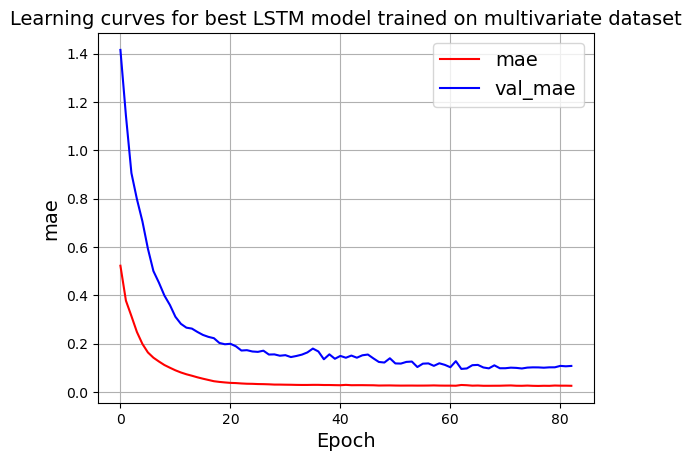

In [59]:
plt.plot(pd.DataFrame(history_lstm_multi.history["mae"]),"r", label="mae")
plt.plot(pd.DataFrame(history_lstm_multi.history["val_mae"]), "b", label="val_mae")
plt.xlabel("Epoch")
plt.ylabel("mae")
plt.title("Learning curves for best LSTM model trained on multivariate dataset")
plt.grid()
plt.legend() 
plt.show()

In [60]:
# Evaluate best LSTM multivariate model
lstm_multi.evaluate(multi_test)

1/1 [==============================] - 0s 86ms/step - loss: 0.0258 - mae: 0.1857


[0.0258267093449831, 0.18573661148548126]

In [61]:
# Build gru model for multivariate series

def build_gru_model_2(hp):
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=3)
    units = hp.Int("units", min_value=24, max_value=32)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-3,
                             sampling="log")
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    gru_hp_model_2 = tf.keras.Sequential()
    gru_hp_model_2.add(tf.keras.layers.InputLayer(input_shape=[None, 2]))
    for _ in range(n_hidden):
        gru_hp_model_2.add(tf.keras.layers.GRU(units,return_sequences=True))
    gru_hp_model_2.add(tf.keras.layers.Dense(7))
    gru_hp_model_2.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,
                  metrics=["mae"])
    return gru_hp_model_2

In [62]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

# using random search
random_search_tuner_gru_multi = kt.RandomSearch(
    build_gru_model_2, objective="val_mae", max_trials=10, overwrite=True,
    directory="stock_price", project_name="gru_rnd_search_multi_rev1",seed=42)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=20, restore_best_weights=True)
random_search_tuner_gru_multi.search(multi_train, validation_data=multi_valid, epochs=300,
                              callbacks=[early_stopping_cb])

Trial 10 Complete [00h 05m 21s]
val_mae: 0.10815996676683426

Best val_mae So Far: 0.08819340914487839
Total elapsed time: 00h 48m 03s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [63]:
top3_gru_multi_models = random_search_tuner_gru_multi.get_best_models(num_models=3)
gru_multi_best_model = top3_gru_multi_models[0]

In [64]:
# best hyperparameter values
top3_gru_multi_params = random_search_tuner_gru_multi.get_best_hyperparameters(num_trials=3)
top3_gru_multi_params[0].values

{'n_hidden': 1, 'units': 29, 'learning_rate': 0.00016756583493598323}

In [65]:
# Build model with best hyperparameters
tf.keras.backend.clear_session()

gru_multi = tf.keras.models.Sequential([
    tf.keras.layers.GRU(29, return_sequences=True, input_shape=[None,2]),
    tf.keras.layers.Dense(7) 
])

opt = tf.keras.optimizers.Adam(learning_rate=0.0001676)
gru_multi.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=20, restore_best_weights=True)
history_gru_multi = gru_multi.fit(multi_train, validation_data=multi_valid, epochs=300,
                                  callbacks=[early_stopping_cb])

Epoch 1/300
113/113 [==============================] - 3s 14ms/step - loss: 0.2463 - mae: 0.6007 - val_loss: 1.4070 - val_mae: 1.9063
Epoch 2/300
113/113 [==============================] - 1s 10ms/step - loss: 0.1475 - mae: 0.4391 - val_loss: 0.9356 - val_mae: 1.4300
Epoch 3/300
113/113 [==============================] - 1s 10ms/step - loss: 0.0806 - mae: 0.3078 - val_loss: 0.6206 - val_mae: 1.0917
Epoch 4/300
113/113 [==============================] - 1s 10ms/step - loss: 0.0518 - mae: 0.2435 - val_loss: 0.4821 - val_mae: 0.9361
Epoch 5/300
113/113 [==============================] - 1s 10ms/step - loss: 0.0392 - mae: 0.2087 - val_loss: 0.4117 - val_mae: 0.8525
Epoch 6/300
113/113 [==============================] - 1s 11ms/step - loss: 0.0309 - mae: 0.1803 - val_loss: 0.3629 - val_mae: 0.7893
Epoch 7/300
113/113 [==============================] - 1s 10ms/step - loss: 0.0247 - mae: 0.1544 - val_loss: 0.3191 - val_mae: 0.7274
Epoch 8/300
113/113 [==============================] - 1s 10ms

Epoch 62/300
113/113 [==============================] - 1s 10ms/step - loss: 0.0010 - mae: 0.0308 - val_loss: 0.0124 - val_mae: 0.1193
Epoch 63/300
113/113 [==============================] - 1s 10ms/step - loss: 0.0010 - mae: 0.0304 - val_loss: 0.0123 - val_mae: 0.1194
Epoch 64/300
113/113 [==============================] - 1s 10ms/step - loss: 0.0010 - mae: 0.0301 - val_loss: 0.0124 - val_mae: 0.1206
Epoch 65/300
113/113 [==============================] - 1s 10ms/step - loss: 9.8388e-04 - mae: 0.0300 - val_loss: 0.0118 - val_mae: 0.1169
Epoch 66/300
113/113 [==============================] - 1s 10ms/step - loss: 9.6319e-04 - mae: 0.0296 - val_loss: 0.0120 - val_mae: 0.1186
Epoch 67/300
113/113 [==============================] - 1s 10ms/step - loss: 9.4863e-04 - mae: 0.0295 - val_loss: 0.0118 - val_mae: 0.1177
Epoch 68/300
113/113 [==============================] - 1s 10ms/step - loss: 9.3424e-04 - mae: 0.0292 - val_loss: 0.0124 - val_mae: 0.1223
Epoch 69/300
113/113 [=================

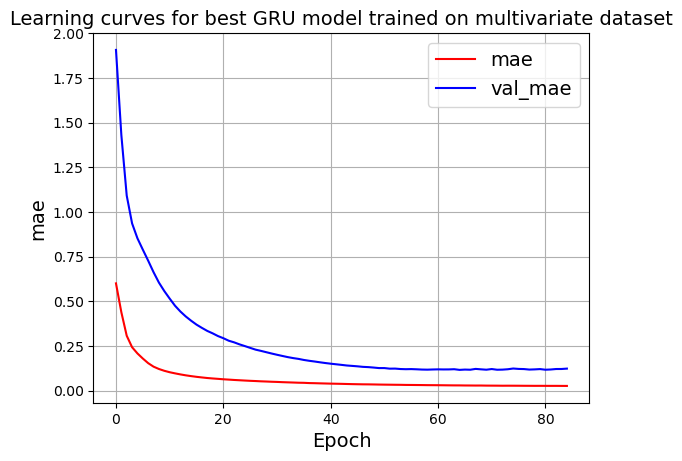

In [66]:
plt.plot(pd.DataFrame(history_gru_multi.history["mae"]),"r", label="mae")
plt.plot(pd.DataFrame(history_gru_multi.history["val_mae"]), "b", label="val_mae")
plt.xlabel("Epoch")
plt.ylabel("mae")
plt.title("Learning curves for best GRU model trained on multivariate dataset")
plt.grid()
plt.legend() 
plt.show()

In [67]:
# Evaluate best GRU multivariate model
gru_multi.evaluate(multi_test)

1/1 [==============================] - 0s 74ms/step - loss: 0.0160 - mae: 0.1387


[0.01596718095242977, 0.13872595131397247]

In [68]:
# Save the best RNN model trained on multiivariate dataset

model_version = "0002"
model_name = "best_multivariate_rnn"
model_path = os.path.join(model_name, model_version)
tf.saved_model.save(lstm_multi, model_path)

INFO:tensorflow:Assets written to: best_multivariate_rnn\0002\assets


INFO:tensorflow:Assets written to: best_multivariate_rnn\0002\assets


In [69]:
# Using AQN.TO close stock price from 2022-09-01 to 2022-09-30(30 days) to predict 2022-10-01 to 2022-10-07(7 days) 
# predicted 5 days of AQN.TO stock close prices from 2022-10-3 to 2022-10-07 using lstm_multi model

x_test_multi = multi_test_scaled[:30].to_numpy().reshape(1, multi_test_scaled[:30].shape[0], multi_test_scaled[:30].shape[1])
y_pred_lstm_multi = lstm_multi.predict(x_test_multi)[0,-1]
print('AQN.TO stock price Oct 3 - 7,2022:',df_uni_test["2022-10-03":"2022-10-07"])
print('y_pred:',(y_pred_lstm_multi[-5:]*multi_train_std[0]) + multi_train_mean[0])

1/1 [==============================] - 1s 746ms/step
AQN.TO stock price Oct 3 - 7,2022: 2022-10-03    15.59
2022-10-04    15.86
2022-10-05    15.45
2022-10-06    14.89
2022-10-07    14.74
Freq: D, Name: AQN.TO, dtype: float64
y_pred: [15.558804 15.626265 15.563866 15.573858 15.646067]


In [70]:
# 5 day Mean Absolute error for AQN.to close stock prices from October 3 October 7,2022 using lstm_multi model

err_multi = tf.keras.metrics.MeanAbsoluteError()
err_multi.update_state(df_uni_test["2022-10-03":"2022-10-07"], (y_pred_lstm_multi[-5:]*multi_train_std[0]) + multi_train_mean[0] )
print("Mean Absolut Error for AQN.to close stock prices from October 3 October 7, 2022:Can$",err_multi.result().numpy())

Mean Absolut Error for AQN.to close stock prices from October 3 October 7, 2022:Can$ 0.39374447


## Forecast AQN.TO stock price using 1D convolutional layer(s) and RNN

In [71]:
# Build Conv1D-lstm model for multivariate series

def build_lstm_model_3(hp):
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=3)
    units = hp.Int("units", min_value=24, max_value=32)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-3,
                             sampling="log")
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    lstm_hp_model_3 = tf.keras.Sequential()
    lstm_hp_model_3.add(tf.keras.layers.Conv1D(filters=units, kernel_size=4, strides=1,
                                               padding="valid", input_shape=[None, 2]))
    for _ in range(n_hidden):
        lstm_hp_model_3.add(tf.keras.layers.LSTM(units,return_sequences=True))
    lstm_hp_model_3.add(tf.keras.layers.Dense(7))
    lstm_hp_model_3.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,
                  metrics=["mae"])
    return lstm_hp_model_3

In [72]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

# With kernel size = 4, the target will begin at index 3( the first output of the convolutional layer will be
# based on input time steps 0 to 2)

convol_train = multi_train.map(lambda X, Y: (X, Y[:, 3:]))
convol_valid = multi_valid.map(lambda X, Y: (X, Y[:, 3:]))

# using random search
random_search_tuner_lstm_convol = kt.RandomSearch(
    build_lstm_model_3, objective="val_mae", max_trials=10, overwrite=True,
    directory="stock_price", project_name="lstm_rnd_search_convol_rev1",seed=42)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=20, restore_best_weights=True)
random_search_tuner_lstm_convol.search(convol_train, validation_data=convol_valid, epochs=300,
                              callbacks=[early_stopping_cb])

Trial 10 Complete [00h 01m 54s]
val_mae: 0.30840998888015747

Best val_mae So Far: 0.09126055985689163
Total elapsed time: 00h 22m 34s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [78]:
top3_lstm_convol_models = random_search_tuner_lstm_convol.get_best_models(num_models=3)
lstm_convol_best_model = top3_lstm_convol_models[0]

In [79]:
# best convol-lstm hyperparameter values
top3_lstm_convol_params = random_search_tuner_lstm_convol.get_best_hyperparameters(num_trials=3)
top3_lstm_convol_params[0].values

{'n_hidden': 1, 'units': 25, 'learning_rate': 0.0005516567488527182}

In [80]:
# Build convol-lstm model with best hyperparameters
tf.keras.backend.clear_session()
tf.random.set_seed(42)

lstm_convol = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=25, kernel_size=4, strides=1,
                                               padding="valid", input_shape=[None, 2]),
    tf.keras.layers.LSTM(25, return_sequences=True),
    tf.keras.layers.Dense(7) 
])

opt = tf.keras.optimizers.Adam(learning_rate=0.0005517)
lstm_convol.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=20, restore_best_weights=True)
history_lstm_convol = lstm_convol.fit(convol_train, validation_data=convol_valid, epochs=300,
                                  callbacks=[early_stopping_cb])

Epoch 1/300
113/113 [==============================] - 3s 13ms/step - loss: 0.1522 - mae: 0.4266 - val_loss: 0.8814 - val_mae: 1.3786
Epoch 2/300
113/113 [==============================] - 1s 8ms/step - loss: 0.0482 - mae: 0.2266 - val_loss: 0.5042 - val_mae: 0.9640
Epoch 3/300
113/113 [==============================] - 1s 8ms/step - loss: 0.0316 - mae: 0.1829 - val_loss: 0.3114 - val_mae: 0.7063
Epoch 4/300
113/113 [==============================] - 1s 8ms/step - loss: 0.0224 - mae: 0.1496 - val_loss: 0.2499 - val_mae: 0.6231
Epoch 5/300
113/113 [==============================] - 1s 8ms/step - loss: 0.0159 - mae: 0.1218 - val_loss: 0.2181 - val_mae: 0.5807
Epoch 6/300
113/113 [==============================] - 1s 8ms/step - loss: 0.0127 - mae: 0.1067 - val_loss: 0.2108 - val_mae: 0.5782
Epoch 7/300
113/113 [==============================] - 1s 9ms/step - loss: 0.0100 - mae: 0.0918 - val_loss: 0.1933 - val_mae: 0.5507
Epoch 8/300
113/113 [==============================] - 1s 8ms/step -

Epoch 62/300
113/113 [==============================] - 1s 8ms/step - loss: 9.0721e-04 - mae: 0.0302 - val_loss: 0.0173 - val_mae: 0.1371
Epoch 63/300
113/113 [==============================] - 1s 8ms/step - loss: 8.6653e-04 - mae: 0.0291 - val_loss: 0.0160 - val_mae: 0.1302
Epoch 64/300
113/113 [==============================] - 1s 8ms/step - loss: 8.7667e-04 - mae: 0.0294 - val_loss: 0.0144 - val_mae: 0.1208
Epoch 65/300
113/113 [==============================] - 1s 8ms/step - loss: 8.6628e-04 - mae: 0.0293 - val_loss: 0.0141 - val_mae: 0.1204
Epoch 66/300
113/113 [==============================] - 1s 8ms/step - loss: 8.6963e-04 - mae: 0.0293 - val_loss: 0.0151 - val_mae: 0.1265
Epoch 67/300
113/113 [==============================] - 1s 8ms/step - loss: 8.8967e-04 - mae: 0.0299 - val_loss: 0.0152 - val_mae: 0.1280
Epoch 68/300
113/113 [==============================] - 1s 8ms/step - loss: 9.0650e-04 - mae: 0.0303 - val_loss: 0.0172 - val_mae: 0.1409
Epoch 69/300
113/113 [============

In [73]:
# Build Conv1D-gru model for multivariate series

def build_gru_model_3(hp):
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=3)
    units = hp.Int("units", min_value=24, max_value=32)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-3,
                             sampling="log")
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    gru_hp_model_3 = tf.keras.Sequential()
    gru_hp_model_3.add(tf.keras.layers.Conv1D(filters=units, kernel_size=4, strides=1,
                                               padding="valid", input_shape=[None, 2]))
    for _ in range(n_hidden):
        gru_hp_model_3.add(tf.keras.layers.GRU(units,return_sequences=True))
    gru_hp_model_3.add(tf.keras.layers.Dense(7))
    gru_hp_model_3.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,
                  metrics=["mae"])
    return gru_hp_model_3

In [74]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

# using random search
random_search_tuner_gru_convol = kt.RandomSearch(
    build_gru_model_3, objective="val_mae", max_trials=10, overwrite=True,
    directory="stock_price", project_name="gru_rnd_search_convol_rev1",seed=42)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=20, restore_best_weights=True)
random_search_tuner_gru_convol.search(convol_train, validation_data=convol_valid, epochs=300,
                              callbacks=[early_stopping_cb])

Trial 10 Complete [00h 03m 38s]
val_mae: 0.10343477874994278

Best val_mae So Far: 0.09253636002540588
Total elapsed time: 00h 32m 31s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [75]:
top3_gru_convol_models = random_search_tuner_gru_convol.get_best_models(num_models=3)
gru_convol_best_model = top3_gru_convol_models[0]

In [76]:
# best convol-gru hyperparameter values
top3_gru_convol_params = random_search_tuner_gru_convol.get_best_hyperparameters(num_trials=3)
top3_gru_convol_params[0].values

{'n_hidden': 2, 'units': 28, 'learning_rate': 0.0008472109609030772}

In [77]:
# Build convol-gru model with best hyperparameters
tf.keras.backend.clear_session()
tf.random.set_seed(42)

gru_convol = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=28, kernel_size=4, strides=1,
                                               padding="valid", input_shape=[None, 2]),
    tf.keras.layers.GRU(28, return_sequences=True),
    tf.keras.layers.GRU(28, return_sequences=True),
    tf.keras.layers.Dense(7) 
])

opt = tf.keras.optimizers.Adam(learning_rate=0.000847)
gru_convol.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=20, restore_best_weights=True)
history_gru_convol = gru_convol.fit(convol_train, validation_data=convol_valid, epochs=300,
                                  callbacks=[early_stopping_cb])

Epoch 1/300
113/113 [==============================] - 4s 18ms/step - loss: 0.0946 - mae: 0.3149 - val_loss: 0.5413 - val_mae: 1.0231
Epoch 2/300
113/113 [==============================] - 1s 10ms/step - loss: 0.0220 - mae: 0.1303 - val_loss: 0.4011 - val_mae: 0.8638
Epoch 3/300
113/113 [==============================] - 1s 9ms/step - loss: 0.0107 - mae: 0.0861 - val_loss: 0.3155 - val_mae: 0.7614
Epoch 4/300
113/113 [==============================] - 1s 9ms/step - loss: 0.0068 - mae: 0.0735 - val_loss: 0.1927 - val_mae: 0.5768
Epoch 5/300
113/113 [==============================] - 1s 9ms/step - loss: 0.0047 - mae: 0.0629 - val_loss: 0.1424 - val_mae: 0.4850
Epoch 6/300
113/113 [==============================] - 1s 9ms/step - loss: 0.0033 - mae: 0.0527 - val_loss: 0.1221 - val_mae: 0.4465
Epoch 7/300
113/113 [==============================] - 1s 9ms/step - loss: 0.0026 - mae: 0.0479 - val_loss: 0.1081 - val_mae: 0.4179
Epoch 8/300
113/113 [==============================] - 1s 9ms/step 

Epoch 61/300
113/113 [==============================] - 1s 9ms/step - loss: 7.3805e-04 - mae: 0.0266 - val_loss: 0.0100 - val_mae: 0.1048
Epoch 62/300
113/113 [==============================] - 1s 9ms/step - loss: 7.2848e-04 - mae: 0.0264 - val_loss: 0.0101 - val_mae: 0.1048
Epoch 63/300
113/113 [==============================] - 1s 10ms/step - loss: 7.1342e-04 - mae: 0.0257 - val_loss: 0.0087 - val_mae: 0.0944
Epoch 64/300
113/113 [==============================] - 1s 9ms/step - loss: 7.0354e-04 - mae: 0.0255 - val_loss: 0.0090 - val_mae: 0.0973
Epoch 65/300
113/113 [==============================] - 1s 9ms/step - loss: 7.1025e-04 - mae: 0.0259 - val_loss: 0.0105 - val_mae: 0.1087
Epoch 66/300
113/113 [==============================] - 1s 9ms/step - loss: 7.2845e-04 - mae: 0.0262 - val_loss: 0.0105 - val_mae: 0.1085
Epoch 67/300
113/113 [==============================] - 1s 9ms/step - loss: 7.1942e-04 - mae: 0.0263 - val_loss: 0.0096 - val_mae: 0.1013
Epoch 68/300
113/113 [===========

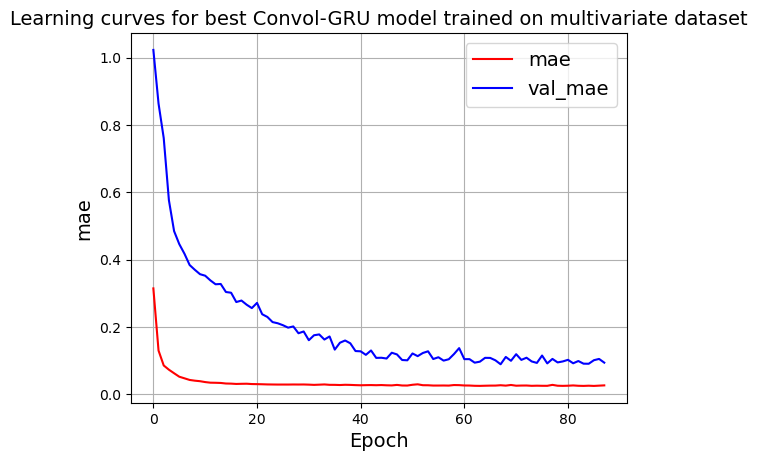

In [81]:
plt.plot(pd.DataFrame(history_gru_convol.history["mae"]),"r", label="mae")
plt.plot(pd.DataFrame(history_gru_convol.history["val_mae"]), "b", label="val_mae")
plt.xlabel("Epoch")
plt.ylabel("mae")
plt.title("Learning curves for best Convol-GRU model trained on multivariate dataset")
plt.grid()
plt.legend() 
plt.show()

In [82]:
# Evaluate best Convol-GRU multivariate model
multi_test = to_seq2seq_dataset_multi(multi_test_scaled)
convol_test = multi_test.map(lambda X, Y: (X, Y[:, 3:]))
gru_convol.evaluate(convol_test)

1/1 [==============================] - 0s 294ms/step - loss: 0.0263 - mae: 0.1888


[0.0262654647231102, 0.1888129860162735]

In [83]:
# Save the best convol-gru model trained on multiivariate dataset

model_version = "0002"
model_name = "best_multivariate_convol_gru"
model_path = os.path.join(model_name, model_version)
tf.saved_model.save(gru_convol, model_path)

INFO:tensorflow:Assets written to: best_multivariate_convol_gru\0002\assets


INFO:tensorflow:Assets written to: best_multivariate_convol_gru\0002\assets


In [84]:
# Using AQN.TO close stock price from 2022-09-01 to 2022-09-30(30 days) to predict 2022-10-01 to 2022-10-07(7 days) 
# predicted 5 days of AQN.to close stock prices from 2022-10-3 to 2022-10-07 using convol-gru model

y_pred_gru_convol = gru_convol.predict(x_test_multi)[0,-1]
print('AQN.TO stock price Oct 3 - 7,2022:',df_uni_test["2022-10-03":"2022-10-07"])
print('y_pred:',(y_pred_gru_convol[-5:]*multi_train_std[0]) + multi_train_mean[0])

1/1 [==============================] - 1s 545ms/step
AQN.TO stock price Oct 3 - 7,2022: 2022-10-03    15.59
2022-10-04    15.86
2022-10-05    15.45
2022-10-06    14.89
2022-10-07    14.74
Freq: D, Name: AQN.TO, dtype: float64
y_pred: [15.537376 15.592075 15.574905 15.641214 15.645533]


In [85]:
# 5 day Mean Absolute error for AQN.to close stock prices from October 3 October 7,2022 using convol-gru model

err_convol_gru = tf.keras.metrics.MeanAbsoluteError()
err_convol_gru.update_state(df_uni_test["2022-10-03":"2022-10-07"], (y_pred_gru_convol[-5:]*multi_train_std[0]) + multi_train_mean[0] )
print("Mean Absolut Error for AQN.to close stock prices from October 3 October 7, 2022:Can$",err_convol_gru.result().numpy())

Mean Absolut Error for AQN.to close stock prices from October 3 October 7, 2022:Can$ 0.4204401


## Forecast AQN.TO stock price using classical methods

In [19]:
# Get dataset
df3 = df_univar["2021-01-01":"2022-10-07"]

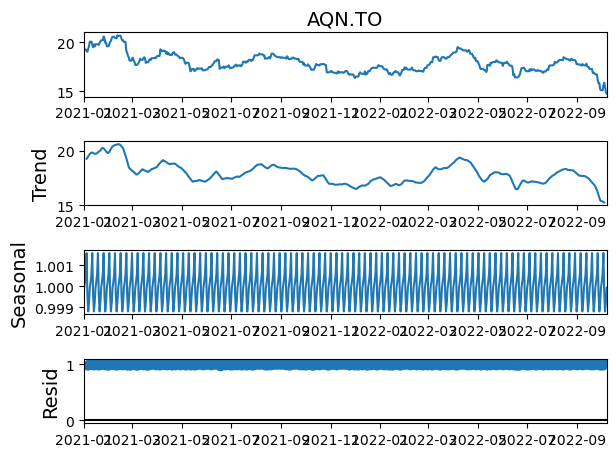

In [21]:
# Get insights from dataset df3 by decomposing the dataset
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df3, model='multiplicative')
result.plot()
plt.show()

<AxesSubplot: >

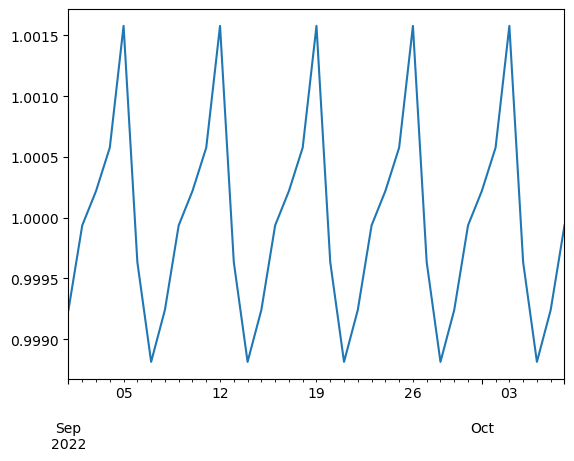

In [22]:
# get the seasonal period which is 7 for this dataset
result.seasonal["2022-09-01":"2022-10-07"].plot()

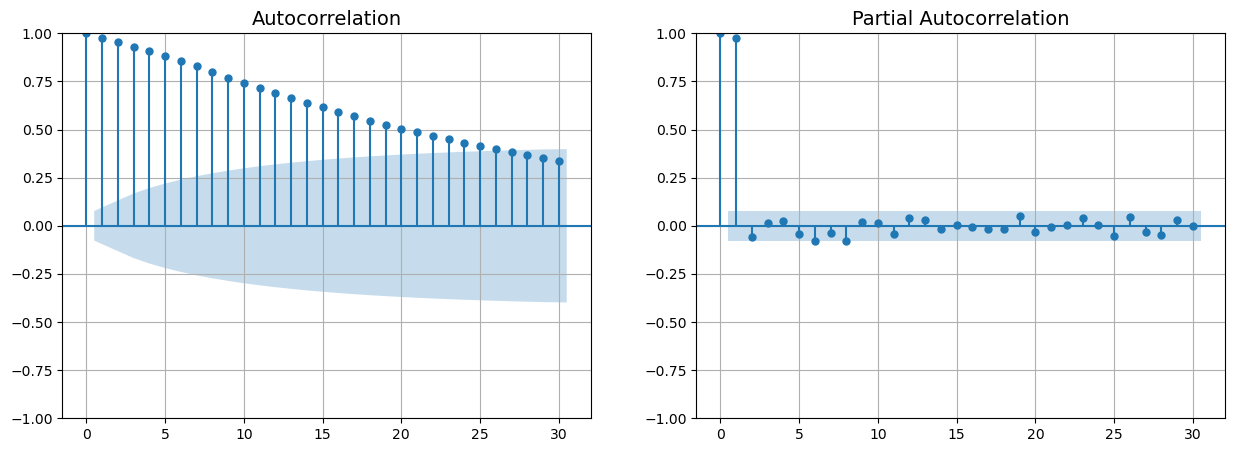

In [24]:
# ACF & PACF Plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df3, ax=axs[0], lags = 30 )
axs[0].grid()
plot_pacf(df3, ax=axs[1], lags=30, method='ywm')
axs[1].grid()
plt.show()

In [8]:
# Grid search sarima hyperparameters
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import yfinance as yf
import pandas as pd

# one-step sarima forecast
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend,
                    enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

In [9]:
# root mean squared error or rmse
def measure_mae(actual, predicted):
    return mean_absolute_error(actual, predicted)

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = sarima_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_mae(test, predictions)
    return error

In [10]:
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
        # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

In [11]:
# grid search configs
def grid_search(data, cfg_list, n_test, parallel= False):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

In [14]:
# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
    models = list()
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c' ,'t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [15]:
if __name__ == '__main__':
    # Download Algonquin Power & Utilities Corp. stock price from January 1,2021 to October 07, 2022
    df4 = yf.download(['AQN.TO'], start='2021-01-01', end='2022-10-07', 
                        progress=False, auto_adjust=True)
    df5 = df4['Close']
    # Original dataset did not have weekend and holiday data.Impute with forward fill data to produce timeseries dataset 
    Date_new1 = pd.date_range(start='2021-01-01', end='2022-10-07', freq='D')
    df5 = df5.reindex(Date_new1, method='ffill' )
    
    # Data split
    n_test = 5

    # model configs
    cfg_list = sarima_configs(seasonal=[7])

    # grid search
    scores = grid_search(df5, cfg_list, n_test)
    print('done')

    # list top 3 configs
    for cfg, error in scores[:3]:
        print(cfg, error)

 > Model[[(0, 0, 0), (0, 0, 0, 7), 'n']] 15.336
 > Model[[(0, 0, 0), (0, 0, 1, 7), 'n']] 7.751
 > Model[[(0, 0, 0), (0, 0, 2, 7), 'n']] 3.633
 > Model[[(0, 0, 0), (0, 1, 0, 7), 'n']] 0.289
 > Model[[(0, 0, 0), (0, 1, 1, 7), 'n']] 0.176
 > Model[[(0, 0, 0), (0, 1, 2, 7), 'n']] 0.178
 > Model[[(0, 0, 0), (1, 0, 0, 7), 'n']] 0.262
 > Model[[(0, 0, 0), (1, 0, 1, 7), 'n']] 0.170
 > Model[[(0, 0, 0), (1, 0, 2, 7), 'n']] 0.172
 > Model[[(0, 0, 0), (1, 1, 0, 7), 'n']] 0.269
 > Model[[(0, 0, 0), (1, 1, 1, 7), 'n']] 0.176
 > Model[[(0, 0, 0), (1, 1, 2, 7), 'n']] 0.180
 > Model[[(0, 0, 0), (2, 0, 0, 7), 'n']] 0.222
 > Model[[(0, 0, 0), (2, 0, 1, 7), 'n']] 0.171
 > Model[[(0, 0, 0), (2, 0, 2, 7), 'n']] 0.172
 > Model[[(0, 0, 0), (2, 1, 0, 7), 'n']] 0.175
 > Model[[(0, 0, 0), (2, 1, 1, 7), 'n']] 0.183
 > Model[[(0, 0, 0), (2, 1, 2, 7), 'n']] 0.182
 > Model[[(0, 0, 0), (0, 0, 0, 7), 'c']] 2.575
 > Model[[(0, 0, 0), (0, 0, 1, 7), 'c']] 1.200
 > Model[[(0, 0, 0), (0, 0, 2, 7), 'c']] 0.734
 > Model[[(0

 > Model[[(0, 0, 2), (2, 0, 0, 7), 'c']] 0.499
 > Model[[(0, 0, 2), (2, 0, 1, 7), 'c']] 0.304
 > Model[[(0, 0, 2), (2, 0, 2, 7), 'c']] 0.428
 > Model[[(0, 0, 2), (2, 1, 0, 7), 'c']] 0.286
 > Model[[(0, 0, 2), (2, 1, 1, 7), 'c']] 0.251
 > Model[[(0, 0, 2), (2, 1, 2, 7), 'c']] 0.267
 > Model[[(0, 0, 2), (0, 0, 0, 7), 't']] 3.233
 > Model[[(0, 0, 2), (0, 0, 1, 7), 't']] 1.480
 > Model[[(0, 0, 2), (0, 0, 2, 7), 't']] 0.888
 > Model[[(0, 0, 2), (0, 1, 0, 7), 't']] 0.540
 > Model[[(0, 0, 2), (0, 1, 1, 7), 't']] 0.504
 > Model[[(0, 0, 2), (0, 1, 2, 7), 't']] 0.510
 > Model[[(0, 0, 2), (1, 0, 0, 7), 't']] 1.112
 > Model[[(0, 0, 2), (1, 0, 1, 7), 't']] 0.311
 > Model[[(0, 0, 2), (1, 0, 2, 7), 't']] 0.596
 > Model[[(0, 0, 2), (1, 1, 0, 7), 't']] 0.543
 > Model[[(0, 0, 2), (1, 1, 1, 7), 't']] 0.361
 > Model[[(0, 0, 2), (1, 1, 2, 7), 't']] 0.433
 > Model[[(0, 0, 2), (2, 0, 0, 7), 't']] 0.940
 > Model[[(0, 0, 2), (2, 0, 1, 7), 't']] 2.053
 > Model[[(0, 0, 2), (2, 0, 2, 7), 't']] 0.751
 > Model[[(0,

 > Model[[(0, 1, 1), (1, 0, 0, 7), 'ct']] 0.356
 > Model[[(0, 1, 1), (1, 0, 1, 7), 'ct']] 0.355
 > Model[[(0, 1, 1), (1, 0, 2, 7), 'ct']] 0.350
 > Model[[(0, 1, 1), (1, 1, 0, 7), 'ct']] 0.430
 > Model[[(0, 1, 1), (1, 1, 1, 7), 'ct']] 0.412
 > Model[[(0, 1, 1), (1, 1, 2, 7), 'ct']] 0.391
 > Model[[(0, 1, 1), (2, 0, 0, 7), 'ct']] 0.350
 > Model[[(0, 1, 1), (2, 0, 1, 7), 'ct']] 0.350
 > Model[[(0, 1, 1), (2, 0, 2, 7), 'ct']] 0.350
 > Model[[(0, 1, 1), (2, 1, 0, 7), 'ct']] 0.424
 > Model[[(0, 1, 1), (2, 1, 1, 7), 'ct']] 0.415
 > Model[[(0, 1, 1), (2, 1, 2, 7), 'ct']] 0.391
 > Model[[(0, 1, 2), (0, 0, 0, 7), 'n']] 0.365
 > Model[[(0, 1, 2), (0, 0, 1, 7), 'n']] 0.370
 > Model[[(0, 1, 2), (0, 0, 2, 7), 'n']] 0.362
 > Model[[(0, 1, 2), (0, 1, 0, 7), 'n']] 0.472
 > Model[[(0, 1, 2), (0, 1, 1, 7), 'n']] 0.371
 > Model[[(0, 1, 2), (0, 1, 2, 7), 'n']] 0.375
 > Model[[(0, 1, 2), (1, 0, 0, 7), 'n']] 0.364
 > Model[[(0, 1, 2), (1, 0, 1, 7), 'n']] 0.371
 > Model[[(0, 1, 2), (1, 0, 2, 7), 'n']] 0.362
 

 > Model[[(1, 0, 1), (0, 0, 0, 7), 'c']] 0.343
 > Model[[(1, 0, 1), (0, 0, 1, 7), 'c']] 0.334
 > Model[[(1, 0, 1), (0, 0, 2, 7), 'c']] 0.357
 > Model[[(1, 0, 1), (0, 1, 0, 7), 'c']] 0.394
 > Model[[(1, 0, 1), (0, 1, 1, 7), 'c']] 0.347
 > Model[[(1, 0, 1), (0, 1, 2, 7), 'c']] 0.350
 > Model[[(1, 0, 1), (1, 0, 0, 7), 'c']] 0.327
 > Model[[(1, 0, 1), (1, 0, 1, 7), 'c']] 0.347
 > Model[[(1, 0, 1), (1, 0, 2, 7), 'c']] 0.342
 > Model[[(1, 0, 1), (1, 1, 0, 7), 'c']] 0.393
 > Model[[(1, 0, 1), (1, 1, 1, 7), 'c']] 0.345
 > Model[[(1, 0, 1), (1, 1, 2, 7), 'c']] 0.348
 > Model[[(1, 0, 1), (2, 0, 0, 7), 'c']] 0.336
 > Model[[(1, 0, 1), (2, 0, 1, 7), 'c']] 0.352
 > Model[[(1, 0, 1), (2, 0, 2, 7), 'c']] 0.345
 > Model[[(1, 0, 1), (2, 1, 0, 7), 'c']] 0.388
 > Model[[(1, 0, 1), (2, 1, 1, 7), 'c']] 0.345
 > Model[[(1, 0, 1), (2, 1, 2, 7), 'c']] 0.346
 > Model[[(1, 0, 1), (0, 0, 0, 7), 't']] 0.350
 > Model[[(1, 0, 1), (0, 0, 1, 7), 't']] 0.346
 > Model[[(1, 0, 1), (0, 0, 2, 7), 't']] 0.385
 > Model[[(1,

 > Model[[(1, 1, 0), (2, 0, 0, 7), 't']] 0.351
 > Model[[(1, 1, 0), (2, 0, 1, 7), 't']] 0.351
 > Model[[(1, 1, 0), (2, 0, 2, 7), 't']] 0.351
 > Model[[(1, 1, 0), (2, 1, 0, 7), 't']] 0.427
 > Model[[(1, 1, 0), (2, 1, 1, 7), 't']] 0.418
 > Model[[(1, 1, 0), (2, 1, 2, 7), 't']] 0.393
 > Model[[(1, 1, 0), (0, 0, 0, 7), 'ct']] 0.352
 > Model[[(1, 1, 0), (0, 0, 1, 7), 'ct']] 0.357
 > Model[[(1, 1, 0), (0, 0, 2, 7), 'ct']] 0.351
 > Model[[(1, 1, 0), (0, 1, 0, 7), 'ct']] 0.461
 > Model[[(1, 1, 0), (0, 1, 1, 7), 'ct']] 0.418
 > Model[[(1, 1, 0), (0, 1, 2, 7), 'ct']] 0.391
 > Model[[(1, 1, 0), (1, 0, 0, 7), 'ct']] 0.358
 > Model[[(1, 1, 0), (1, 0, 1, 7), 'ct']] 0.357
 > Model[[(1, 1, 0), (1, 0, 2, 7), 'ct']] 0.351
 > Model[[(1, 1, 0), (1, 1, 0, 7), 'ct']] 0.434
 > Model[[(1, 1, 0), (1, 1, 1, 7), 'ct']] 0.417
 > Model[[(1, 1, 0), (1, 1, 2, 7), 'ct']] 0.398
 > Model[[(1, 1, 0), (2, 0, 0, 7), 'ct']] 0.352
 > Model[[(1, 1, 0), (2, 0, 1, 7), 'ct']] 0.351
 > Model[[(1, 1, 0), (2, 0, 2, 7), 'ct']] 0.35

 > Model[[(2, 0, 0), (1, 0, 0, 7), 'n']] 0.321
 > Model[[(2, 0, 0), (1, 0, 1, 7), 'n']] 0.344
 > Model[[(2, 0, 0), (1, 0, 2, 7), 'n']] 0.366
 > Model[[(2, 0, 0), (1, 1, 0, 7), 'n']] 0.394
 > Model[[(2, 0, 0), (1, 1, 1, 7), 'n']] 0.347
 > Model[[(2, 0, 0), (1, 1, 2, 7), 'n']] 0.340
 > Model[[(2, 0, 0), (2, 0, 0, 7), 'n']] 0.361
 > Model[[(2, 0, 0), (2, 0, 1, 7), 'n']] 0.343
 > Model[[(2, 0, 0), (2, 0, 2, 7), 'n']] 0.359
 > Model[[(2, 0, 0), (2, 1, 0, 7), 'n']] 0.396
 > Model[[(2, 0, 0), (2, 1, 1, 7), 'n']] 0.358
 > Model[[(2, 0, 0), (2, 1, 2, 7), 'n']] 0.351
 > Model[[(2, 0, 0), (0, 0, 0, 7), 'c']] 0.344
 > Model[[(2, 0, 0), (0, 0, 1, 7), 'c']] 0.341
 > Model[[(2, 0, 0), (0, 0, 2, 7), 'c']] 0.366
 > Model[[(2, 0, 0), (0, 1, 0, 7), 'c']] 0.394
 > Model[[(2, 0, 0), (0, 1, 1, 7), 'c']] 0.348
 > Model[[(2, 0, 0), (0, 1, 2, 7), 'c']] 0.351
 > Model[[(2, 0, 0), (1, 0, 0, 7), 'c']] 0.335
 > Model[[(2, 0, 0), (1, 0, 1, 7), 'c']] 0.346
 > Model[[(2, 0, 0), (1, 0, 2, 7), 'c']] 0.344
 > Model[[(2,

 > Model[[(2, 0, 2), (0, 0, 0, 7), 't']] 0.372
 > Model[[(2, 0, 2), (0, 0, 1, 7), 't']] 0.318
 > Model[[(2, 0, 2), (0, 0, 2, 7), 't']] 0.472
 > Model[[(2, 0, 2), (0, 1, 0, 7), 't']] 0.404
 > Model[[(2, 0, 2), (0, 1, 1, 7), 't']] 0.443
 > Model[[(2, 0, 2), (0, 1, 2, 7), 't']] 0.472
 > Model[[(2, 0, 2), (1, 0, 0, 7), 't']] 0.449
 > Model[[(2, 0, 2), (1, 0, 1, 7), 't']] 0.417
 > Model[[(2, 0, 2), (1, 0, 2, 7), 't']] 0.418
 > Model[[(2, 0, 2), (1, 1, 0, 7), 't']] 0.428
 > Model[[(2, 0, 2), (1, 1, 1, 7), 't']] 0.448
 > Model[[(2, 0, 2), (1, 1, 2, 7), 't']] 0.472
 > Model[[(2, 0, 2), (2, 0, 0, 7), 't']] 0.481
 > Model[[(2, 0, 2), (2, 0, 1, 7), 't']] 0.476
 > Model[[(2, 0, 2), (2, 0, 2, 7), 't']] 0.481
 > Model[[(2, 0, 2), (2, 1, 0, 7), 't']] 0.425
 > Model[[(2, 0, 2), (2, 1, 1, 7), 't']] 0.443
 > Model[[(2, 0, 2), (2, 1, 2, 7), 't']] 0.474
 > Model[[(2, 0, 2), (0, 0, 0, 7), 'ct']] 0.364
 > Model[[(2, 0, 2), (0, 0, 1, 7), 'ct']] 0.336
 > Model[[(2, 0, 2), (0, 0, 2, 7), 'ct']] 0.455
 > Model[[

 > Model[[(2, 1, 1), (2, 0, 0, 7), 'ct']] 0.373
 > Model[[(2, 1, 1), (2, 0, 1, 7), 'ct']] 0.373
 > Model[[(2, 1, 1), (2, 0, 2, 7), 'ct']] 0.372
 > Model[[(2, 1, 1), (2, 1, 0, 7), 'ct']] 0.441
 > Model[[(2, 1, 1), (2, 1, 1, 7), 'ct']] 0.430
 > Model[[(2, 1, 1), (2, 1, 2, 7), 'ct']] 0.404
 > Model[[(2, 1, 2), (0, 0, 0, 7), 'n']] 0.370
 > Model[[(2, 1, 2), (0, 0, 1, 7), 'n']] 0.382
 > Model[[(2, 1, 2), (0, 0, 2, 7), 'n']] 0.360
 > Model[[(2, 1, 2), (0, 1, 0, 7), 'n']] 0.455
 > Model[[(2, 1, 2), (0, 1, 1, 7), 'n']] 0.384
 > Model[[(2, 1, 2), (0, 1, 2, 7), 'n']] 0.381
 > Model[[(2, 1, 2), (1, 0, 0, 7), 'n']] 0.376
 > Model[[(2, 1, 2), (1, 0, 1, 7), 'n']] 0.379
 > Model[[(2, 1, 2), (1, 0, 2, 7), 'n']] 0.362
 > Model[[(2, 1, 2), (1, 1, 0, 7), 'n']] 0.460
 > Model[[(2, 1, 2), (1, 1, 1, 7), 'n']] 0.386
 > Model[[(2, 1, 2), (1, 1, 2, 7), 'n']] 0.367
 > Model[[(2, 1, 2), (2, 0, 0, 7), 'n']] 0.380
 > Model[[(2, 1, 2), (2, 0, 1, 7), 'n']] 0.378
 > Model[[(2, 1, 2), (2, 0, 2, 7), 'n']] 0.371
 > Mode

In [22]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults

# train the best model using grid search parameters
train_arima, test_arima = train_test_split(df5, n_test)
best_model_arima = ARIMA(train_arima, order=(0,0,1), seasonal_order=(2,0,1,7),
                        enforce_invertibility=False, enforce_stationarity=False)
best_model_arima_fit = best_model_arima.fit()
best_model_arima_fit.save('best_model_arima.pkl')

In [23]:
# Load best arima model
load_best_arima_model = ARIMAResults.load('best_model_arima.pkl')

In [32]:
y_forecast = load_best_arima_model.forecast(steps=5)
y_forecast

2022-10-03    15.626515
2022-10-04    16.024017
2022-10-05    16.047317
2022-10-06    15.455575
2022-10-07    15.400035
Freq: D, Name: predicted_mean, dtype: float64

In [31]:
# mean_absolute_error for period 2022-10-03 to 2022-10-07
mae_best_sarima_model = measure_mae(test_arima, y_forecast)
mae_best_sarima_model

0.3746919231458854

## Conclusion

The objective of the project is to forecast 5 days(October 3 - 7, 2022) of stock close price
for Algonquin Power & Utilities Corp.(Ticker: AQN.TO).
The dataset was obtain from Yahoo Financials for the period January 04, 2010 to October 28, 2022.

The Mean Absolute Error for various models are shown below:
fine tune RNN model hyperparameters using an univariate dataset
best model mean absolute error: Can$2.52

fine tune RNN model hyperparameters using multivariate dataset
best model mean absolute error: Can$0.39

fine tune 1D Convolutional/RNN model hyperparameters using multivariate dataset
best model mean absolute error: Can$0.42

fine tune ARIMA model hyperparameters 
best model mean absolute error: Can$0.37

The ARIMA model outperform the RNN models